In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
df = pd.read_csv(r'/content/gdrive/My Drive/dataa/train.csv')
df.head()

,id,comment_text,primary,secondary,tertiary
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            159571 non-null  object
 1   comment_text  159571 non-null  object
 2   primary       159571 non-null  int64 
 3   secondary     159571 non-null  int64 
 4   tertiary      159571 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 6.1+ MB


# EDA

Text(0, 0.5, 'Types of comments')

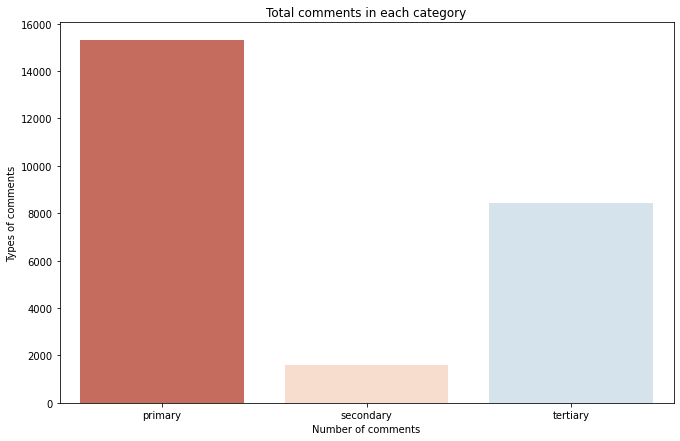

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(11,7))
sns.barplot(x = list(df.columns[2:]), y= list(df.iloc[:,2:].sum()),palette=sns.color_palette("RdBu",n_colors=4))
plt.title('Total comments in each category')
plt.xlabel('Number of comments')
plt.ylabel('Types of comments')

In [19]:
count = 0
for i in range(len(df)):
    n = df.iloc[i,2:].sum()
    if n > 1:
        count = count + 1
    
print('Total multi-labeled comments:',count)

Total multi-labeled comments: 8004


Text(0.5, 0, 'number of labels')

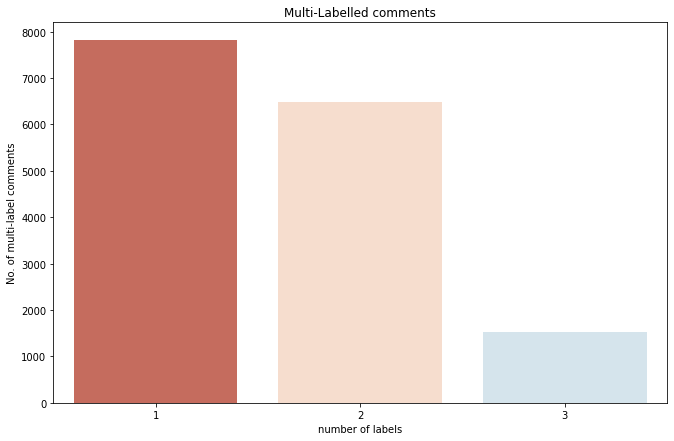

In [20]:
multi_count = df.iloc[:,2:].sum(axis=1).value_counts()

plt.figure(figsize=(11,7))
sns.barplot(x = multi_count.index[1:], y = multi_count[1:],palette=sns.color_palette("RdBu",n_colors=4))
plt.title('Multi-Labelled comments')
plt.ylabel('No. of multi-label comments')
plt.xlabel('number of labels')

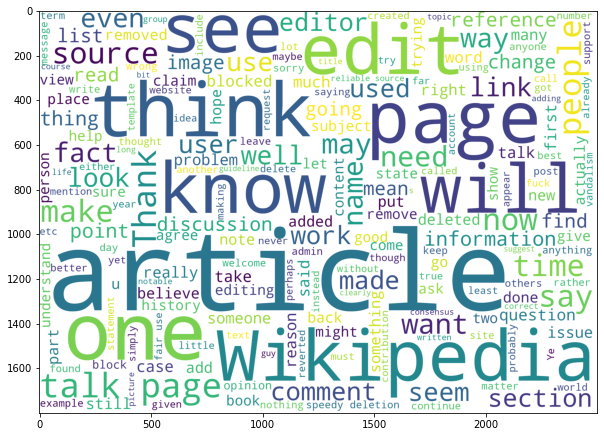

In [21]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(10,8))
text = df.comment_text.values

cloud = WordCloud(stopwords=STOPWORDS, 
                  background_color='white', 
                  width=2500, 
                  height=1800).generate(''.join(text))
plt.imshow(cloud)

# Cleaning the text data:

In [22]:
import re
import string
from nltk.corpus import stopwords

def clean_text(x):
    '''
    The first two lines replace characters to spaces.
    Than we remove punctuations from text using string
    and finally all the stopwords in the text.
    '''
    text = re.sub(r"\'", r'', x) 
    text = re.sub(r'\n', r' ', text)
    nopunc = [i for i in text if i not in string.punctuation]
    nopunc = ''.join(nopunc)
    stop_word = [j for j in nopunc.split() if j.lower() not in stopwords.words('english')]
    return ' '.join(stop_word)

In [23]:
import datetime
import nltk
nltk.download('stopwords')
before = datetime.datetime.now()
df['clean_comments'] = df['comment_text'].apply(clean_text)
after = datetime.datetime.now()
print('Time consumed by text cleaning operation: ', after - before)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Time consumed by text cleaning operation:  0:16:36.691030


In [24]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

def stemm(sentence):
    '''
    Function first splits the sentence to words
    than stem each word to base form and finally
    concat it to string \'stem_word\' '''
    stem_word = ''
    for word in sentence.split():
        stem = stemmer.stem(word)
        stem_word += stem
        stem_word += ' '
    return stem_word

In [25]:
import datetime
before = datetime.datetime.now()

df['clean_comments'] = df['clean_comments'].apply(stemm)

after = datetime.datetime.now()
print('Time consumed by stemming operation: ', after - before)

Time consumed by stemming operation:  0:01:12.259136


# Text before and after applying stemming and cleaning text:

In [26]:
print(df['comment_text'][0])
print('-'*40)
print(df['clean_comments'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
----------------------------------------
explan edit made usernam hardcor metallica fan revert werent vandal closur gas vote new york doll fac pleas dont remov templat talk page sinc im retir now892053827 


### TF-IDF of a word gives a product of how frequent this word is in the document multiplied by how unique the word is w.r.t. the entire corpus of documents.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

vectrizer = TfidfVectorizer(analyzer='word',ngram_range=(1,3))
X = vectrizer.fit_transform(df['clean_comments'])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    df.drop(['id','comment_text','clean_comments'],axis=1),
                                                    test_size=0.33, 
                                                    random_state=42)

### In an “one-to-rest” strategy, we build multiple independent classifiers and, choose the class for which the confidence is maximized.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score

model = OneVsRestClassifier(estimator=LogisticRegression())
model.fit(X_train, y_train)

prediction = model.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, prediction))
print('hamming loss : ', hamming_loss(y_test, prediction))

Accuracy Score:  0.9198997322395032
hamming loss :  0.033846699203048544
